This notebook is part of the [Machine Learning class](https://github.com/erachelson/MLclass) by [Emmanuel Rachelson](https://personnel.isae-supaero.fr/emmanuel-rachelson?lang=en) and was written by Erwan Lecarpentier and Jonathan Sprauel.

License: CC-BY-SA-NC.

<div style="font-size:22pt; line-height:25pt; font-weight:bold; text-align:center;">XGBoost<br>Introduction to XGBoost</div>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
sns.set_style('whitegrid')

from sklearn import datasets
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score
import time
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline


from xgboost import XGBClassifier
import xgboost as xgb

# A complete exemple : Classification of stars, Galaxies, Quasars

For this first application of XGBoost, we will try to classify observations of space to be either stars, galaxies or quasars.
We are using data from the [Sloan Digital Sky Survey](http://www.sdss.org/)

### About the SDSS
The Sloan Digital Sky Survey is a project which offers public data of space observations. Observations have been made since 1998 and have been made accessible to everyone who is interested.

For this purpose a special 2.5 m diameter telescope was built at the Apache Point Observatory in New Mexico, USA. The telescope uses a camera of 30 CCD-Chips with 2048x2048 image points each. The chips are ordered in 5 rows with 6 chips in each row. Each row observes the space through different optical filters (u, g, r, i, z) at wavelengths of approximately 354, 476, 628, 769, 925 nm.

The telescope covers around one quarter of the earth's sky - therefore focuses on the northern part of the sky.

In [3]:
sdss_df = pd.read_csv('../Skyserver_SQL2_27_2018 6_51_39 PM.csv', skiprows=1)
sdss_df.head()

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,class,redshift,plate,mjd,fiberid
0,1237648704577142822,183.531326,0.089693,19.47406,17.04240,15.94699,15.50342,15.22531,752,301,4,267,3722360139651588096,STAR,-0.000009,3306,54922,491
1,1237648704577142859,183.598371,0.135285,18.66280,17.21449,16.67637,16.48922,16.39150,752,301,4,267,363814405953054720,STAR,-0.000055,323,51615,541
2,1237648704577208477,183.680207,0.126185,19.38298,18.19169,17.47428,17.08732,16.80125,752,301,4,268,323274319570429952,GALAXY,0.123111,287,52023,513
3,1237648704577273907,183.870529,0.049911,17.76536,16.60272,16.16116,15.98233,15.90438,752,301,4,269,3722365362331820032,STAR,-0.000111,3306,54922,510
4,1237648704577273909,183.883288,0.102557,17.55025,16.26342,16.43869,16.55492,16.61326,752,301,4,269,3722365912087633920,STAR,0.000590,3306,54922,512


In [4]:
sdss_df.describe()

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,redshift,plate,mjd,fiberid
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.0,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.237650e+18,175.529987,14.836148,18.619355,17.371931,16.840963,16.583579,16.422833,981.034800,301.0,3.648700,302.380100,1.645022e+18,0.143726,1460.986400,52943.533300,353.069400
std,1.173967e+12,47.783439,25.212207,0.828656,0.945457,1.067764,1.141805,1.203188,273.305024,0.0,1.666183,162.577763,2.013998e+18,0.388774,1788.778371,1511.150651,206.298149
min,1.237647e+18,8.235100,-5.382632,12.988970,12.799550,12.431600,11.947210,11.610410,308.000000,301.0,1.000000,11.000000,2.995782e+17,-0.004136,266.000000,51578.000000,1.000000
25%,1.237649e+18,157.370946,-0.539035,18.178035,16.815100,16.173333,15.853705,15.618285,752.000000,301.0,2.000000,184.000000,3.389250e+17,0.000081,301.000000,51900.000000,186.750000
50%,1.237649e+18,180.394514,0.404166,18.853095,17.495135,16.858770,16.554985,16.389945,756.000000,301.0,4.000000,299.000000,4.966580e+17,0.042591,441.000000,51997.000000,351.000000
75%,1.237651e+18,201.547279,35.649397,19.259232,18.010145,17.512675,17.258550,17.141447,1331.000000,301.0,5.000000,414.000000,2.881300e+18,0.092579,2559.000000,54468.000000,510.000000
max,1.237652e+18,260.884382,68.542265,19.599900,19.918970,24.802040,28.179630,22.833060,1412.000000,301.0,6.000000,768.000000,9.468834e+18,5.353854,8410.000000,57481.000000,1000.000000


In the previous cells, we only checked a few classical elements when facing a dataset : 
* There is no missing data, that we should complete
* Most features remain within reasonable values, for each columns

The goal is to classify each data into either the Galaxy, Star or QSO class.

In [5]:
sdss_df['class'].value_counts()

GALAXY    4998
STAR      4152
QSO        850
Name: class, dtype: int64

## Data Analysis

Before applying any classification algorithm, let's look a bit more and transform the data : first we remove the column that obviously won't help classify into the correct class, such as the objects id and parameters of the camera at the moment of observation.

In [6]:
sdss_df.drop(['objid', 'run', 'rerun', 'camcol', 'field', 'specobjid'], axis=1, inplace=True)
sdss_df.head(1)

,ra,dec,u,g,r,i,z,class,redshift,plate,mjd,fiberid
0,183.531326,0.089693,19.47406,17.0424,15.94699,15.50342,15.22531,STAR,-0.000009,3306,54922,491


Next we look at a few interesting features (univariate analysis) : by plotting the distribution of each class along this feature, we can estimate if this feature can help in classifying the data.

For instance, we can see that redshift seems to have good correlation, while ascension and declination does not differ significantly between the 3 classes.

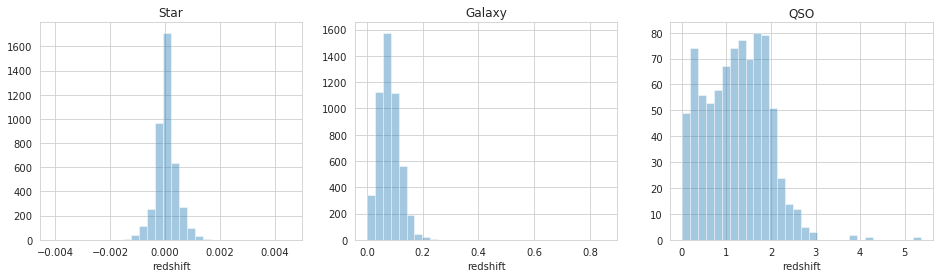

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 4))
ax = sns.distplot(sdss_df[sdss_df['class']=='STAR'].redshift, bins = 30, ax = axes[0], kde = False)
ax.set_title('Star')
ax = sns.distplot(sdss_df[sdss_df['class']=='GALAXY'].redshift, bins = 30, ax = axes[1], kde = False)
ax.set_title('Galaxy')
ax = sns.distplot(sdss_df[sdss_df['class']=='QSO'].redshift, bins = 30, ax = axes[2], kde = False)
ax = ax.set_title('QSO')

Text(0.5, 1, 'Equatorial coordinates')

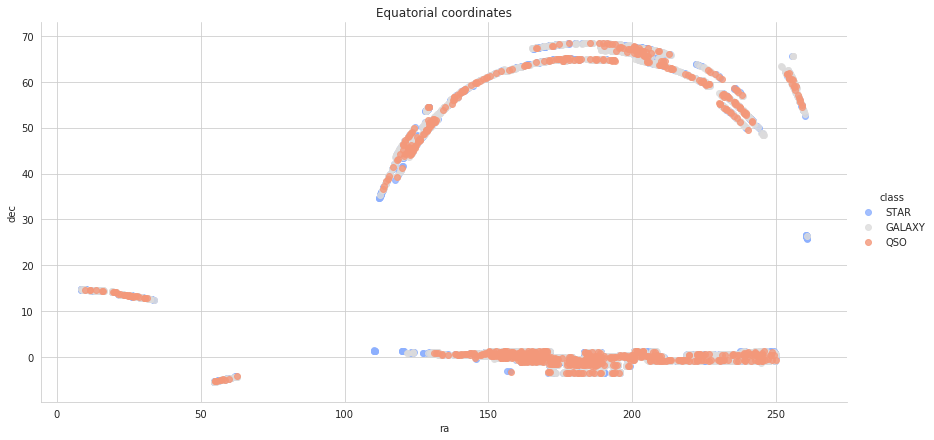

In [9]:
sns.lmplot(x='ra', y='dec', data=sdss_df, hue='class', fit_reg=False, palette='coolwarm', height=6, aspect=2)
plt.title('Equatorial coordinates')

Finally, we transform a few features : we transform the different bands through a PCA, we encode the classes and scale the extreme values.

In [11]:
sdss_df_fe = sdss_df

# encode class labels to integers
le = LabelEncoder()
y_encoded = le.fit_transform(sdss_df_fe['class'])
sdss_df_fe['class'] = y_encoded

# Principal Component Analysis
pca = PCA(n_components=3)
ugriz = pca.fit_transform(sdss_df_fe[['u', 'g', 'r', 'i', 'z']])

# update dataframe 
sdss_df_fe = pd.concat((sdss_df_fe, pd.DataFrame(ugriz)), axis=1)
sdss_df_fe.rename({0: 'PCA_1', 1: 'PCA_2', 2: 'PCA_3'}, axis=1, inplace = True)
sdss_df_fe.drop(['u', 'g', 'r', 'i', 'z'], axis=1, inplace=True)
sdss_df_fe.head()

,ra,dec,class,redshift,plate,mjd,fiberid,PCA_1,PCA_2,PCA_3
0,183.531326,0.089693,2,-0.000009,3306,54922,491,-1.507202,-1.377293,-0.265119
1,183.598371,0.135285,2,-0.000055,323,51615,541,-0.195758,-0.028410,-0.155695
2,183.680207,0.126185,0,0.123111,287,52023,513,1.297604,-0.590023,0.140338
3,183.870529,0.049911,2,-0.000111,3306,54922,510,-1.446117,0.566685,-0.009272
4,183.883288,0.102557,2,0.000590,3306,54922,512,-0.849271,1.287505,-0.397689


In [12]:
scaler = MinMaxScaler()
sdss = scaler.fit_transform(sdss_df_fe.drop('class', axis=1))

## Classification

Using XGboost is similar in many ways with the sklearn api : we define a model and call the *fit* function on the training data; the *predict* function makes the prediction.

<div class="alert alert-success">
<b>Exercice 1 :</b> Complete the following functions.
</div>

In [21]:
X_train, X_test, y_train, y_test = train_test_split(sdss,y_encoded, test_size=0.33)

In [22]:
%%time
xgbC = XGBClassifier(n_estimators=100)
xgbC.fit(X_train,y_train)
preds = xgbC.predict(X_test) 
# Note:the score depends on random split test/train
# if you have 100 score, you probably forgot to remove class from X
acc_xgb = (preds == y_test).sum().astype(float) / len(preds)*100
print("XGBoost's prediction accuracy is: %3.2f" % (acc_xgb))


XGBoost's prediction accuracy is: 99.42
CPU times: user 1.09 s, sys: 1.62 ms, total: 1.09 s
Wall time: 1.09 s


In [23]:
%%time
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train,y_train)
preds = rfc.predict(X_test)
acc_rfc = (preds == y_test).sum().astype(float) / len(preds)*100
print("Scikit-Learn's Random Forest Classifier's prediction accuracy is: %3.2f" % (acc_rfc))

Scikit-Learn's Random Forest Classifier's prediction accuracy is: 99.30
CPU times: user 1.2 s, sys: 3.61 ms, total: 1.2 s
Wall time: 1.2 s


In [24]:
%%time
svc = SVC()
svc.fit(X_train,y_train)
preds = svc.predict(X_test)
acc_svc = (preds == y_test).sum().astype(float) / len(preds)*100
print("Scikit-Learn's Support Vector Machine Classifier's prediction accuracy is: %3.2f" % (acc_svc))

Scikit-Learn's Support Vector Machine Classifier's prediction accuracy is: 94.24
CPU times: user 595 ms, sys: 20 ms, total: 615 ms
Wall time: 613 ms


We can focus a bit more on the performance comparison between XGBoost and Random Forest, in term of optimality :

In [25]:

rfc_cv = RandomForestClassifier(n_estimators=100)
scores = cross_val_score(rfc_cv, X_train, y_train, cv=10, scoring = "accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [0.98507463 0.99552239 0.98955224 0.99253731 0.98656716 0.99253731
 0.98656716 0.98955224 0.99850746 0.99552239]
Mean: 0.9911940298507462
Standard Deviation: 0.004245212732336696


In [26]:
xgb_cv = XGBClassifier(n_estimators=100)
scores = cross_val_score(xgb_cv, X_train, y_train, cv=10, scoring = "accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [0.99253731 0.99402985 0.99104478 0.99402985 0.99104478 0.99402985
 0.98955224 0.99253731 1.         0.99552239]
Mean: 0.9934328358208955
Standard Deviation: 0.0027682443270136523


Finally, XGBoost also allows to obtain the feature importance list :

In [27]:
importances = pd.DataFrame({
    'Feature': sdss_df_fe.drop('class', axis=1).columns,
    'Importance': xgbC.feature_importances_
})
importances = importances.sort_values(by='Importance', ascending=False)
importances = importances.set_index('Feature')
importances

,Importance
Feature,
redshift,0.883715
PCA_3,0.037598
PCA_2,0.015321
fiberid,0.014473
PCA_1,0.012217
plate,0.009650
mjd,0.009610
ra,0.009387
dec,0.008028


# A focus on the parameters

XGBoost has <[many parameters](https://xgboost.readthedocs.io/en/latest/parameter.html); we will explain them a bit by following this guideline, that woks well on most problems :

* Choose a relatively high learning rate (**learning_rate**)
* Determine the optimum number of trees for this learning rate. (**n_estimators**)
* Tune tree-specific parameters ( **max_depth, min_child_weight, gamma, subsample, colsample_bytree** for instance) for the decided learning rate and number of trees.
* Tune regularization parameters (**lambda, alpha**)

For most of the functions, instead of relying on sklearn cross_valisation function we will use XGBoost function called "cv" which performs cross-validation at each boosting iteration and returns the optimum number of trees required.

<div class="alert alert-success">
<b>Exercice 2 :</b> Complete the following functions.
</div>





In [31]:
num_round = 100
param = {
    "learning_rate" :0.3,
    "n_estimators":1000,
    'silent': 1,
    'objective': 'multi:softprob',
    'num_class': 3
}

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

cvresult = xgb.cv(param, dtrain, nfold=10, num_boost_round=param['n_estimators'],  early_stopping_rounds=50)

bst = xgb.train(param, dtrain, num_round)
preds = bst.predict(dtest)
predictions = np.asarray([np.argmax(line) for line in preds])
print (precision_score(y_test, predictions, average='macro'))

0.989025299276601


In [29]:
print(cvresult.shape)

(17, 4)



<div class="alert alert-success">
<b>Exercice 3 :</b> Complete the following code to tune the tree parameters : max_depth and min_child_weight
</div>

In [33]:
from sklearn.model_selection import GridSearchCV

param = {
    "learning_rate" :0.3,
    "n_estimators":17,
    "max_depth":7,
    "min_child_weight":2,
    'objective': 'multi:softprob',
    'num_class': 3
}

param_test1 = {
 'max_depth':[3,5,7,9],
 'min_child_weight':[1,3,5]
}
gsearch1 = GridSearchCV(estimator = XGBClassifier(param), param_grid = param_test1, cv=10)

gsearch1.fit(X_train, y_train)
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

({'mean_fit_time': array([0.97524006, 0.92163901, 0.89843652, 1.38356473, 1.41042483,
         1.30229089, 1.73765128, 1.41608131, 1.34930437, 1.81315181,
         1.54478524, 1.40585117]),
  'std_fit_time': array([0.02788099, 0.01280208, 0.00887414, 0.01525676, 0.03760264,
         0.06362651, 0.09152592, 0.02731384, 0.05514199, 0.04961351,
         0.04789949, 0.03319499]),
  'mean_score_time': array([0.00408227, 0.00395164, 0.00404544, 0.00542452, 0.00612929,
         0.00575974, 0.00682499, 0.00540335, 0.0055532 , 0.00599661,
         0.00556967, 0.00557547]),
  'std_score_time': array([0.00023644, 0.00023173, 0.00031198, 0.00034239, 0.00145722,
         0.00080055, 0.0019769 , 0.00035544, 0.00067092, 0.00040365,
         0.00036227, 0.00040258]),
  'param_max_depth': masked_array(data=[3, 3, 3, 5, 5, 5, 7, 7, 7, 9, 9, 9],
               mask=[False, False, False, False, False, False, False, False,
                     False, False, False, False],
         fill_value='?',
         

The process can be repeated iteratively with the remaining parameters. A good heuristic is to follow this order next :
Gamma, then (subsample and colsample_bytree) together, then reg_lambda and reg_alpha.


<div class="alert alert-success">
<b>Exercice 3 :</b> Complete the tuning and try to obtain the best performance of the model.
</div>

In [ ]:

# replace parameters for final evaluation
param = {
    "learning_rate" :0.1,
    "n_estimators":76,
    "max_depth":6,
    "min_child_weight":1,
    "gamma":0,
    "subsample":0.8,
    "colsample_bytree":0.8,
    "nthread":4,
    "scale_pos_weight":1,
    'silent': 1,
    'objective': 'multi:softprob',
    'num_class': 3
}


bst = xgb.train(param, dtrain, num_round)
preds = bst.predict(dtest)
predictions = np.asarray([np.argmax(line) for line in preds])
print (precision_score(y_test, predictions, average='macro'))


# Conclusion of the notebook

In the notebook, we have seen the basic functions to use XGBoost. 
The next two notebooks will be more open-ended : the first one will be focused on the ensemble methods, while the second one will be focused on the tuning of the parameters, with regards to the tradeoff between biais and variance.

Sources : 
* https://www.kaggle.com/lucidlenn/data-analysis-and-classification-using-xgboost
* https://github.com/dmlc/xgboost/tree/master/demo